### Task 3: Linear Dataset

#### Importing libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report

#### Loading datasets

In [7]:
df1 = pd.read_csv("../Datasets/LinearDataset/Class1.txt",delimiter=' ', header=None)
df2 = pd.read_csv("../Datasets/LinearDataset/Class2.txt",delimiter=' ', header=None)
df3 = pd.read_csv("../Datasets/LinearDataset/Class3.txt",delimiter=' ', header=None)

#### Dividing training and testing data

In [8]:
df1_train = df1[:int(len(df1)*0.7)]
df1_test = df1[int(len(df1)*0.7):]
df2_train = df2[:int(len(df2)*0.7)]
df2_test = df2[int(len(df2)*0.7):]
df3_train = df3[:int(len(df3)*0.7)]
df3_test = df3[int(len(df3)*0.7):]

#### Fisher linear discriminant analysis (FDA)

In [9]:
def fda_one_vs_one(train_data_list, test_data_list, num_components=1, gmm_components=None):
    """
    Apply FDA pairwise, train Bayes classifiers, and classify using one-vs-one voting.
    Supports both unimodal and multimodal Gaussian models.
    """
    num_classes = len(train_data_list)
    class_pairs = [(i, j) for i in range(num_classes) for j in range(i + 1, num_classes)]
    pairwise_classifiers = {}

    # Train pairwise classifiers
    for class_1, class_2 in class_pairs:
        print(f"Training pair: Class {class_1} vs Class {class_2}")

        # Combine data for the two classes
        data_1, data_2 = train_data_list[class_1], train_data_list[class_2]
        labels = np.array([0] * len(data_1) + [1] * len(data_2))
        combined_data = np.vstack([data_1, data_2])

        # Apply FDA
        lda = LDA(n_components=num_components)
        reduced_data = lda.fit_transform(combined_data, labels)

        if gmm_components is None:
            # Unimodal Gaussian model
            mean_1 = np.mean(reduced_data[labels == 0], axis=0)
            cov_1 = np.cov(reduced_data[labels == 0], rowvar=False)
            mean_2 = np.mean(reduced_data[labels == 1], axis=0)
            cov_2 = np.cov(reduced_data[labels == 1], rowvar=False)

            # Ensure covariance matrices are 2D
            cov_1 = np.atleast_2d(cov_1)
            cov_2 = np.atleast_2d(cov_2)

            model = {
                "lda": lda,
                "mean_1": mean_1,
                "cov_1": cov_1,
                "mean_2": mean_2,
                "cov_2": cov_2
            }
        else:
            # Multimodal Gaussian model using GMM
            gmm_1 = GaussianMixture(n_components=gmm_components, random_state=42).fit(reduced_data[labels == 0])
            gmm_2 = GaussianMixture(n_components=gmm_components, random_state=42).fit(reduced_data[labels == 1])
            model = {
                "lda": lda,
                "gmm_1": gmm_1,
                "gmm_2": gmm_2
            }

        # Save the model
        pairwise_classifiers[(class_1, class_2)] = model

    # Classify test data
    predictions = []
    true_labels = []
    for class_idx, test_data in enumerate(test_data_list):
        for point in test_data:
            votes = []
            for (class_1, class_2), clf in pairwise_classifiers.items():
                lda = clf["lda"]
                reduced_point = lda.transform([point])

                if gmm_components is None:
                    # Unimodal Gaussian classification
                    mean_1, cov_1 = clf["mean_1"], clf["cov_1"]
                    mean_2, cov_2 = clf["mean_2"], clf["cov_2"]

                    diff_1 = reduced_point - mean_1
                    log_det_1 = np.log(np.linalg.det(cov_1))
                    prob_1 = np.exp(-0.5 * diff_1 @ np.linalg.inv(cov_1) @ diff_1.T) / \
                             np.sqrt((2 * np.pi) ** len(reduced_point) * np.linalg.det(cov_1))

                    diff_2 = reduced_point - mean_2
                    log_det_2 = np.log(np.linalg.det(cov_2))
                    prob_2 = np.exp(-0.5 * diff_2 @ np.linalg.inv(cov_2) @ diff_2.T) / \
                             np.sqrt((2 * np.pi) ** len(reduced_point) * np.linalg.det(cov_2))
                else:
                    # Multimodal Gaussian classification using GMM
                    prob_1 = np.exp(clf["gmm_1"].score_samples(reduced_point))[0]
                    prob_2 = np.exp(clf["gmm_2"].score_samples(reduced_point))[0]

                # Vote for the class with higher probability
                votes.append(class_1 if prob_1 > prob_2 else class_2)

            # Majority voting
            predicted_class = Counter(votes).most_common(1)[0][0]
            predictions.append(predicted_class)
            true_labels.append(class_idx)

    # Classification Report
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)
    model_type = "Unimodal Gaussian" if gmm_components is None else f"GMM ({gmm_components} components)"
    print(f"One-vs-One FDA + {model_type} Classifier Report:")
    print(classification_report(true_labels, predictions))
    return predictions

# Example Workflow
train_data_list = [df1_train.to_numpy(), df2_train.to_numpy(), df3_train.to_numpy()]
test_data_list = [df1_test.to_numpy(), df2_test.to_numpy(), df3_test.to_numpy()]

# Unimodal Gaussian
predictions_unimodal = fda_one_vs_one(train_data_list, test_data_list, num_components=1, gmm_components=None)

# Multimodal Gaussian (GMM)
predictions_multimodal_2 = fda_one_vs_one(train_data_list, test_data_list, num_components=1, gmm_components=2)
predictions_multimodal_4 = fda_one_vs_one(train_data_list, test_data_list, num_components=1, gmm_components=4)
predictions_multimodal_4 = fda_one_vs_one(train_data_list, test_data_list, num_components=1, gmm_components=8)
predictions_multimodal_4 = fda_one_vs_one(train_data_list, test_data_list, num_components=1, gmm_components=16)


Training pair: Class 0 vs Class 1
Training pair: Class 0 vs Class 2
Training pair: Class 1 vs Class 2
One-vs-One FDA + Unimodal Gaussian Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       150
           2       1.00      1.00      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00      1.00       450
weighted avg       1.00      1.00      1.00       450

Training pair: Class 0 vs Class 1
Training pair: Class 0 vs Class 2
Training pair: Class 1 vs Class 2
One-vs-One FDA + GMM (2 components) Classifier Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       150
           1       1.00      1.00      1.00       150
           2       1.00      1.00      1.00       150

    accuracy                           1.00       450
   macro avg       1.00      1.00 

#### Decision boundary plot

Processing pair: Class 0 vs Class 1


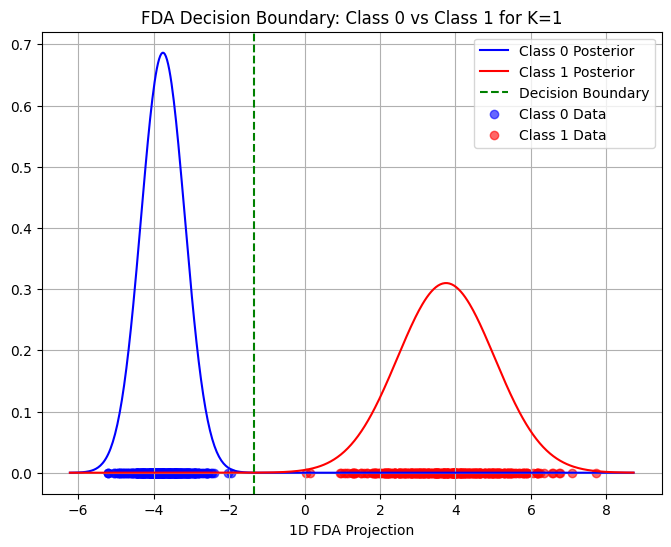

Processing pair: Class 0 vs Class 2


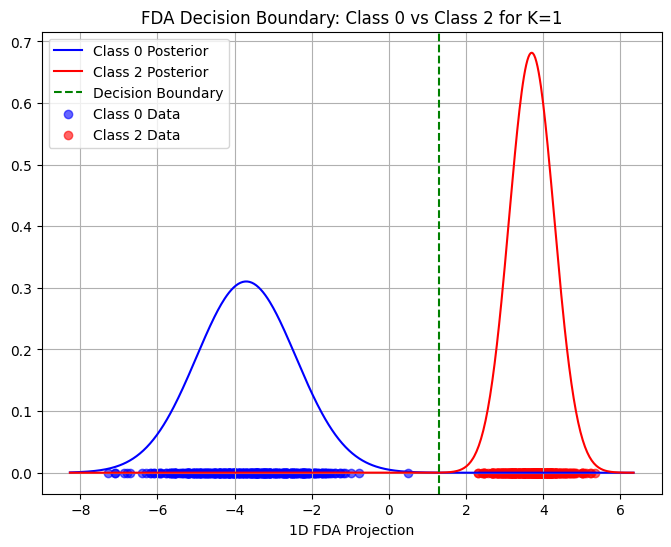

Processing pair: Class 1 vs Class 2


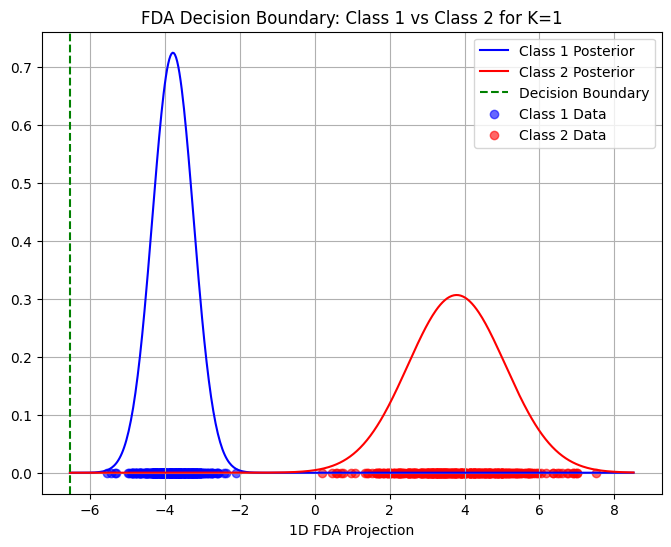

Processing pair: Class 0 vs Class 1


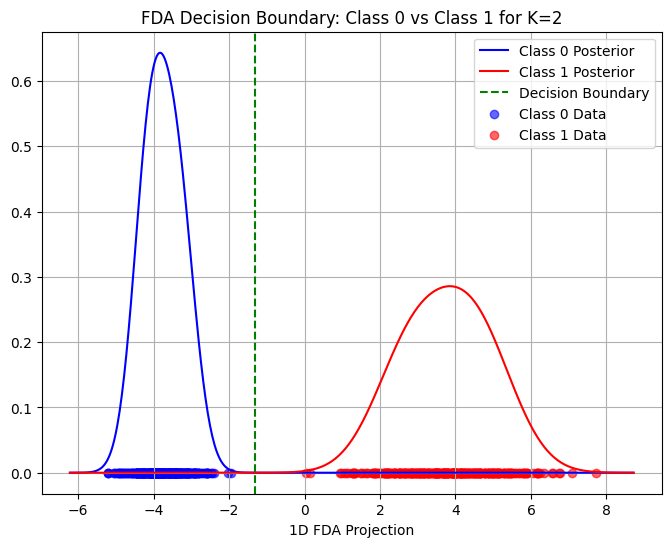

Processing pair: Class 0 vs Class 2


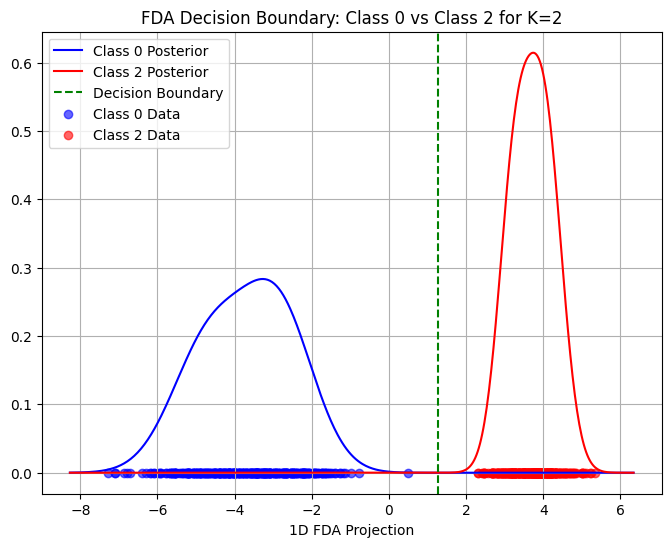

Processing pair: Class 1 vs Class 2


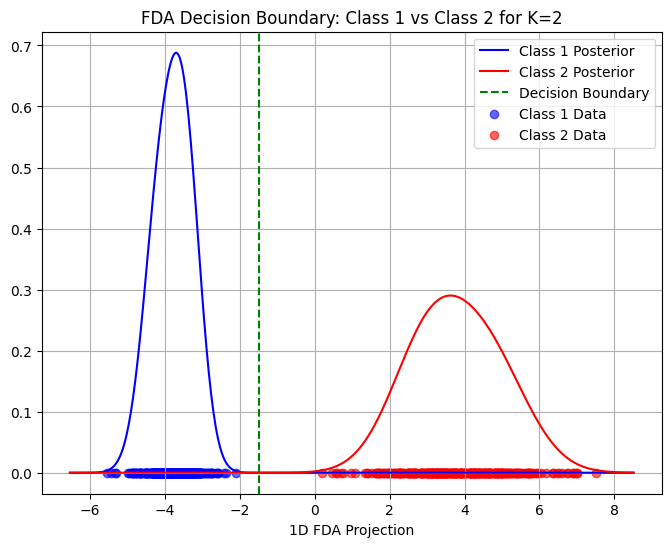

Processing pair: Class 0 vs Class 1


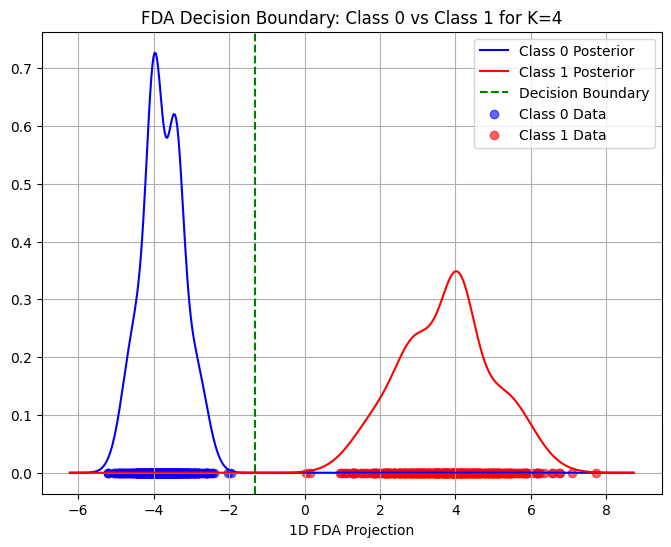

Processing pair: Class 0 vs Class 2


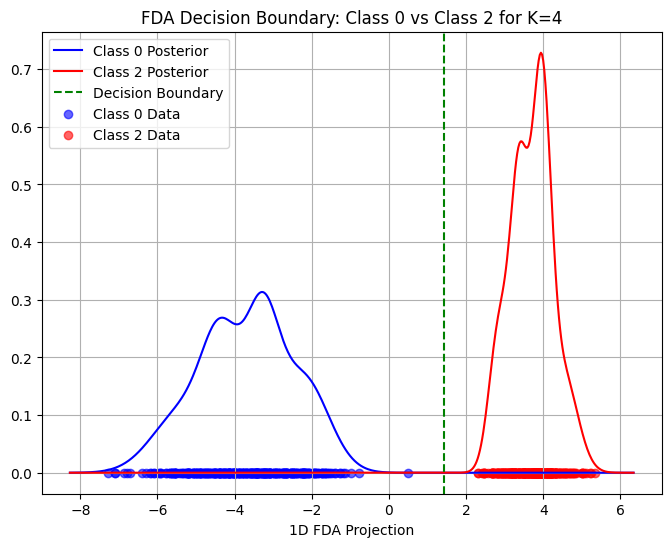

Processing pair: Class 1 vs Class 2


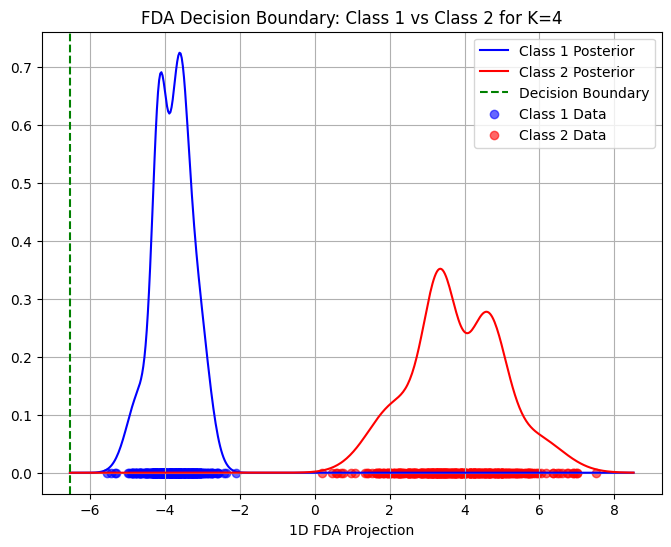

Processing pair: Class 0 vs Class 1


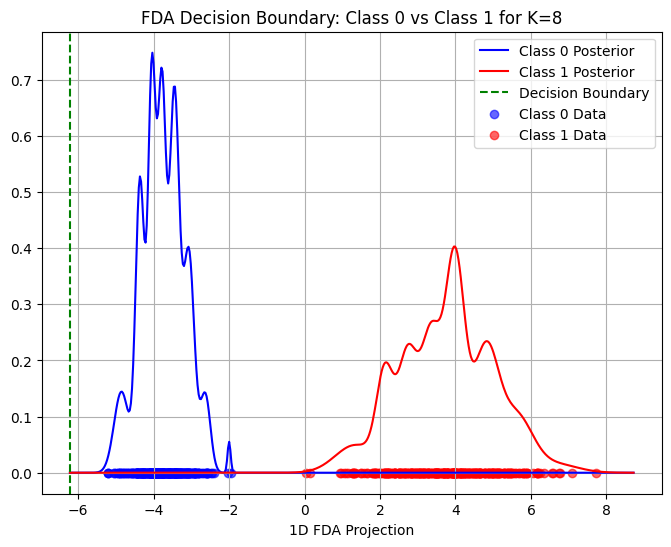

Processing pair: Class 0 vs Class 2


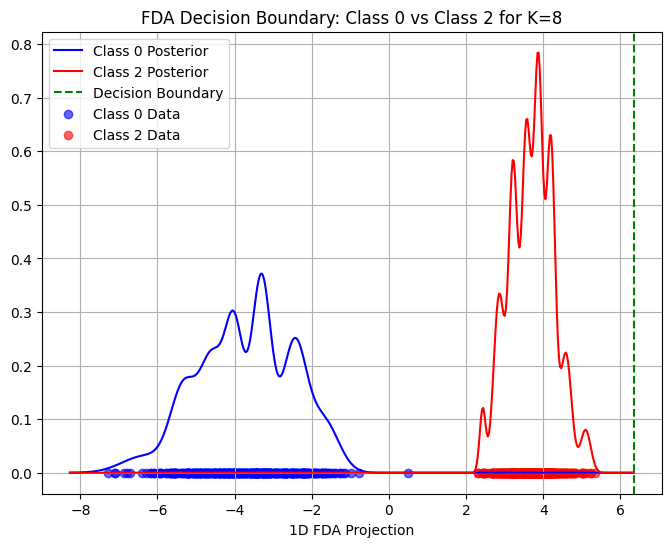

Processing pair: Class 1 vs Class 2


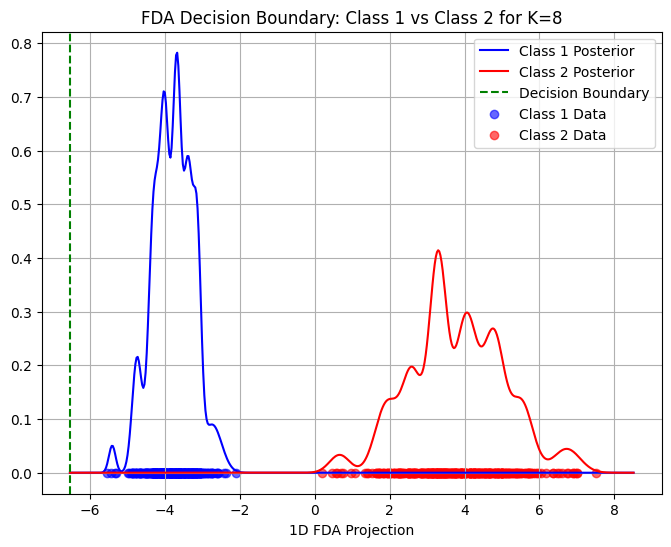

Processing pair: Class 0 vs Class 1


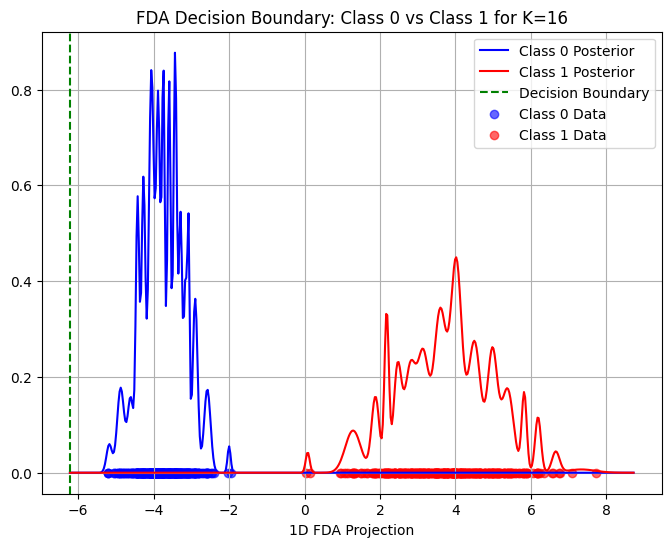

Processing pair: Class 0 vs Class 2


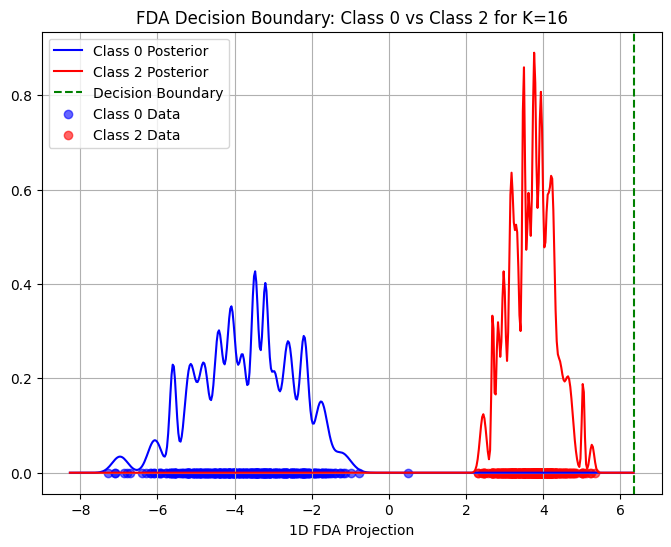

Processing pair: Class 1 vs Class 2


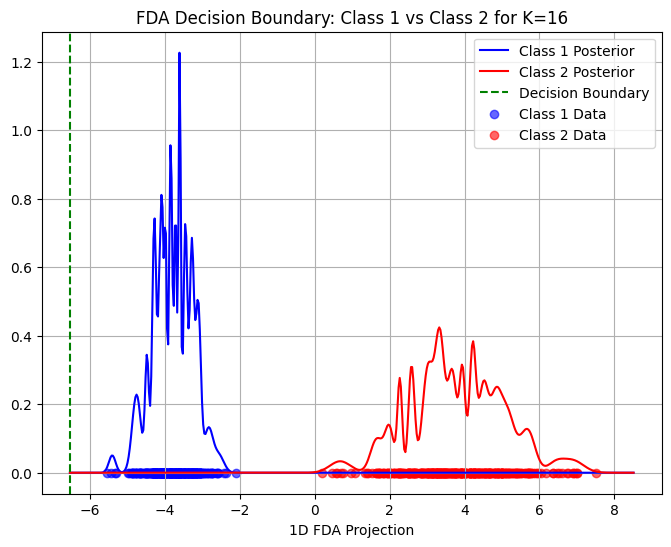

In [10]:
def plot_decision_boundary_fda_pairwise(train_data_list, k):
    """
    Visualize the decision boundary for each pair of classes using FDA and Bayes classifier.
    """
    class_pairs = [(0, 1), (0, 2), (1, 2)]
    for pair in class_pairs:
        class_1, class_2 = pair
        print(f"Processing pair: Class {class_1} vs Class {class_2}")

        # Combine data for the two classes
        data_pair = np.vstack([train_data_list[class_1], train_data_list[class_2]])
        labels_pair = np.hstack([np.zeros(len(train_data_list[class_1])),
                                 np.ones(len(train_data_list[class_2]))])

        # Apply FDA to reduce to 1D
        lda = LDA(n_components=1)
        data_pair_lda = lda.fit_transform(data_pair, labels_pair)

        # Train GMM for each class
        gmm_1 = GaussianMixture(n_components=k, random_state=42).fit(data_pair_lda[labels_pair == 0])
        gmm_2 = GaussianMixture(n_components=k, random_state=42).fit(data_pair_lda[labels_pair == 1])

        # Generate grid points in 1D space
        x_min, x_max = data_pair_lda.min() - 1, data_pair_lda.max() + 1
        x = np.linspace(x_min, x_max, 500).reshape(-1, 1)

        # Compute posteriors for each grid point
        log_prob_1 = gmm_1.score_samples(x)
        log_prob_2 = gmm_2.score_samples(x)
        posteriors_1 = np.exp(log_prob_1)
        posteriors_2 = np.exp(log_prob_2)

        # Decision boundary: Where posteriors are equal
        decision_boundary = x[np.abs(posteriors_1 - posteriors_2).argmin()]

        # Plot
        plt.figure(figsize=(8, 6))
        plt.plot(x, posteriors_1, label=f"Class {class_1} Posterior", color="blue")
        plt.plot(x, posteriors_2, label=f"Class {class_2} Posterior", color="red")
        plt.axvline(decision_boundary, color="green", linestyle="--", label="Decision Boundary")

        # Scatter plot of 1D-reduced data points
        plt.scatter(data_pair_lda[labels_pair == 0], np.zeros_like(data_pair_lda[labels_pair == 0]),
                    color="blue", label=f"Class {class_1} Data", alpha=0.6)
        plt.scatter(data_pair_lda[labels_pair == 1], np.zeros_like(data_pair_lda[labels_pair == 1]),
                    color="red", label=f"Class {class_2} Data", alpha=0.6)

        plt.title(f"FDA Decision Boundary: Class {class_1} vs Class {class_2} for K={k}")
        plt.xlabel("1D FDA Projection")
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage
plot_decision_boundary_fda_pairwise(train_data_list, k=1)
plot_decision_boundary_fda_pairwise(train_data_list, k=2)
plot_decision_boundary_fda_pairwise(train_data_list, k=4)
plot_decision_boundary_fda_pairwise(train_data_list, k=8)
plot_decision_boundary_fda_pairwise(train_data_list, k=16)
